In [1]:
import os
import pandas as pd
import numpy as np
import nltk
import praw
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud, STOPWORDS 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import datetime as dt
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

### Flairs considered

In [2]:
flairs = ["AskIndia", "Non-Political", "[R]eddiquette", 
          "Scheduled", "Photography", "Science/Technology", "Politics",
          "Business/Finance", "Policy/Economy", "Sports", "Food", "AMA", "Coronavirus",
         "CAA-NRC-NPR" ]

In [3]:
import warnings
warnings.filterwarnings("ignore")
## Remember to add documentation before sending
from tqdm import tqdm

### Cell below sets up Reddit api to scrap data
1. https://www.storybench.org/how-to-scrape-reddit-with-python/
2. We tried scraping 14k datapoints
3. But we could scrap only 2898 datapoints



### Data Fetching
1. Setup the reddit api
2. Scraps Flair, title, ID, URL, SCORE, Comments
3. If you are hearing the word first time--> It simply means TAGS

In [4]:
# # https://www.storybench.org/how-to-scrape-reddit-with-python/


reddit = praw.Reddit(client_id='#', client_secret='#',
                     user_agent='#', username='#', password='#')

subreddit = reddit.subreddit('india')
topics_dict = {"flair":[], "title":[], "score":[], "id":[], "url":[], "comms_num": [], "created": [], "body":[], "author":[], "comments":[]}


def get_date(created):
    return dt.datetime.fromtimestamp(created)


for flair in tqdm(flairs):
  
  get_subreddits = subreddit.search(flair, limit=1000)
  
  for submission in get_subreddits:
    
    topics_dict["flair"].append(flair)
    topics_dict["title"].append(submission.title)
    topics_dict["score"].append(submission.score)
    topics_dict["id"].append(submission.id)
    topics_dict["url"].append(submission.url)
    topics_dict["comms_num"].append(submission.num_comments)
    topics_dict["created"].append(submission.created)
    topics_dict["body"].append(submission.selftext)
    topics_dict["author"].append(submission.author)
    
    submission.comments.replace_more(limit=None)
    comment = ''
    for top_level_comment in submission.comments:
        comment = comment + ' ' + top_level_comment.body
    topics_dict["comments"].append(comment)
    
topics_data = pd.DataFrame(topics_dict)
# # _timestamp = topics_data["created"].apply(get_date)
# # topics_data = topics_data.assign(timestamp = _timestamp)
# # del topics_data['created']
topics_data.to_csv('reddit-india-data.csv', index=False)

In [6]:
topics_data.shape

In [7]:
topics_data.to_csv('reddit-india-data.csv', index=False)

In [8]:
df=pd.read_csv("reddit-india-data.csv")
df.columns

Index(['flair', 'title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'author', 'comments'],
      dtype='object')

In [9]:
df.shape

(2898, 10)

In [10]:
df.head(5)

,flair,title,score,id,url,comms_num,created,body,author,comments
0,AskIndia,4 days ago we had pending orders of 100 millio...,92,fwjdqr,https://www.reddit.com/r/india/comments/fwjdqr...,6,1.586290e+09,> We are getting frantic calls from our pharma...,india_ko_vanakkam,"Modi has Stockholm syndrome To be fair, the e..."
1,AskIndia,Randians who were big time users of dating app...,19,fizkkk,https://www.reddit.com/r/india/comments/fizkkk...,19,1.584298e+09,I'd my own stint with these apps(a couple of m...,__knockknockturnal__,Someone matched with me just to tell me that ...
2,AskIndia,What does r/India thinks about the Flat Earthers?,8,f25vx0,https://www.reddit.com/r/india/comments/f25vx0...,31,1.581441e+09,"I encountered a Foreigner in IG who says "" Rou...",Dev1003,I haven't found a Indian yet who believes ear...
3,AskIndia,People who left their 9 to 5 jobs to pursue a ...,44,dtvliq,https://www.reddit.com/r/india/comments/dtvliq...,34,1.573333e+09,Couldn't add AskIndia flair from the mobile br...,c0mrade34,"An Engineer, doing advertisement shoots since..."
4,AskIndia,Somebody want to kill my full family what to do?,98,b7pvwt,https://www.reddit.com/r/india/comments/b7pvwt...,24,1.554080e+09,"It's now 24hrs, But local police station is no...",amitkumarthakur,Calm down.\r\nGo to the SP office of your tow...


In [12]:
df['flair'].value_counts()

Coronavirus           249
Politics              249
Food                  244
AskIndia              236
Scheduled             234
Business/Finance      233
Sports                232
Photography           222
Science/Technology    221
Policy/Economy        220
Non-Political         216
AMA                   213
CAA-NRC-NPR           111
[R]eddiquette          18
Name: flair, dtype: int64

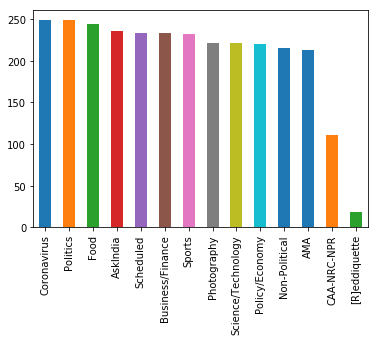

In [17]:
df['flair'].value_counts().plot.bar()
plt.show()

In [18]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", "nan","https", "www", "com" ])

### Cell below plots top 50 words in title

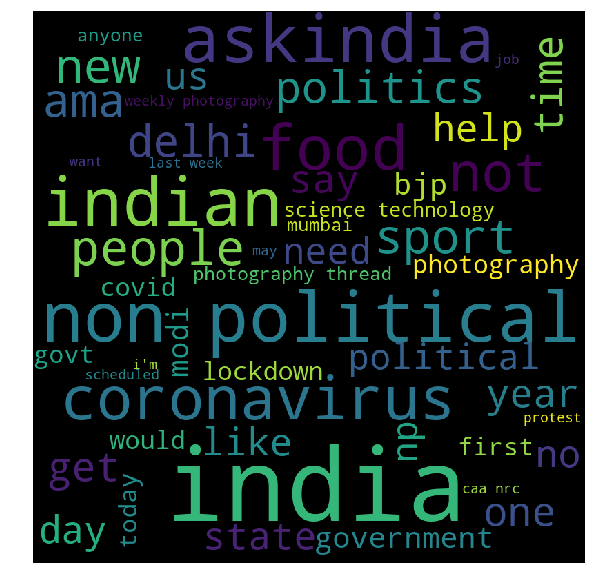

In [51]:
comment_words = '' 
# stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.title: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,  max_words=50,
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


### Cell below plots top 150 words in body

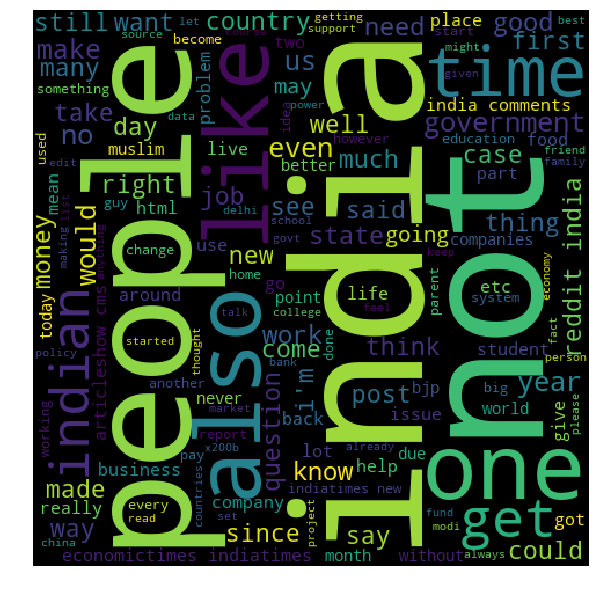

In [52]:
comment_words = '' 
# stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.body: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 480, height = 480,  max_words=150,
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


### Top Words in Body for different flairs 

For Flair  AskIndia


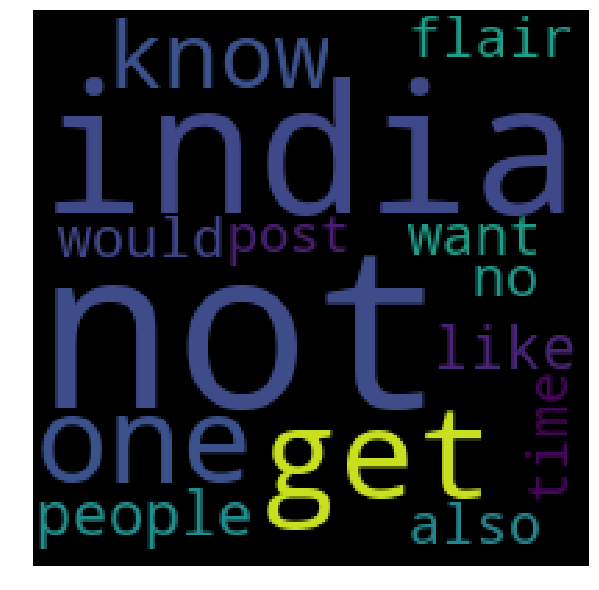

For Flair  Non-Political


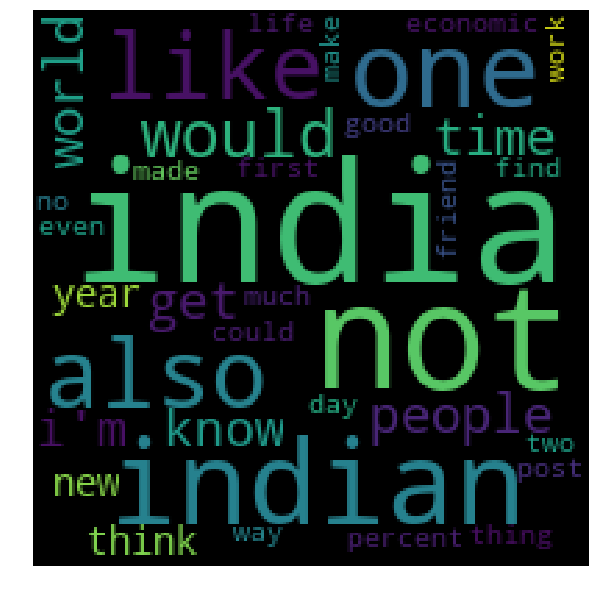

For Flair  [R]eddiquette


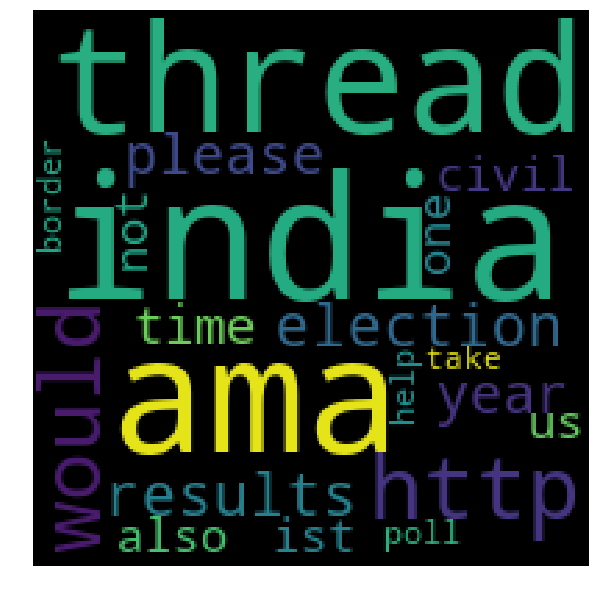

For Flair  Scheduled


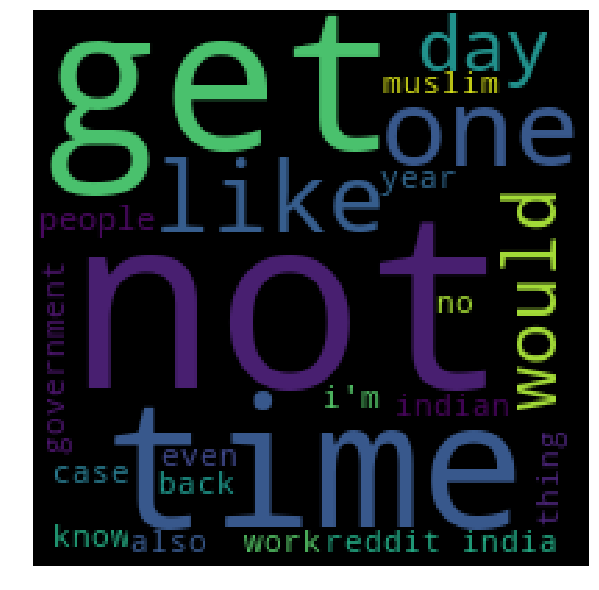

For Flair  Photography


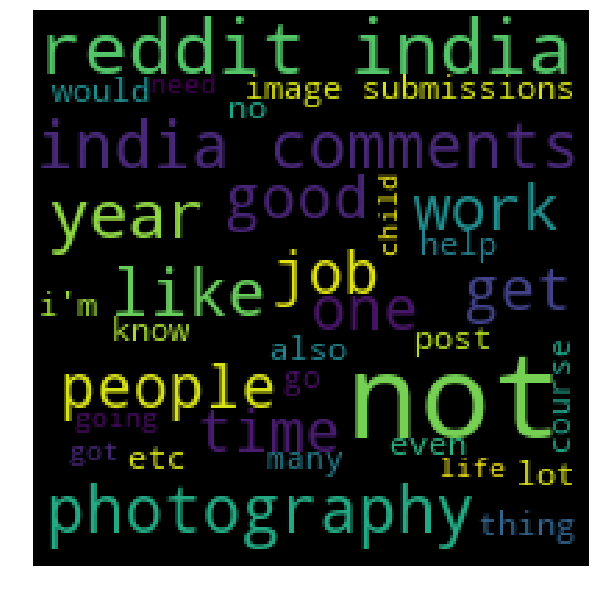

For Flair  Science/Technology


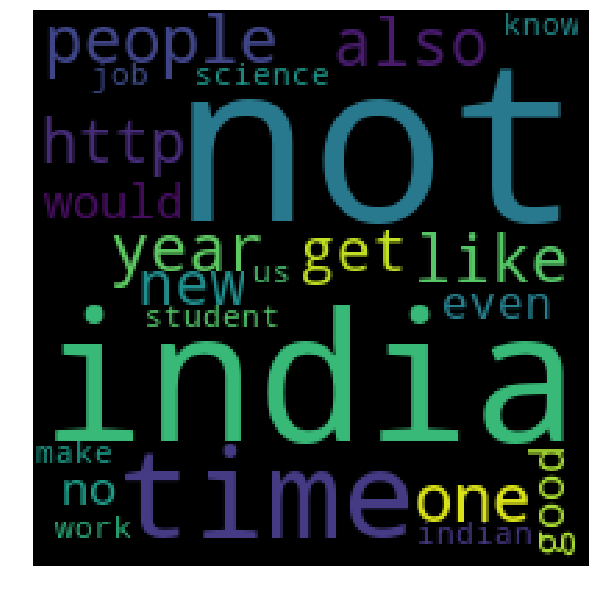

For Flair  Politics


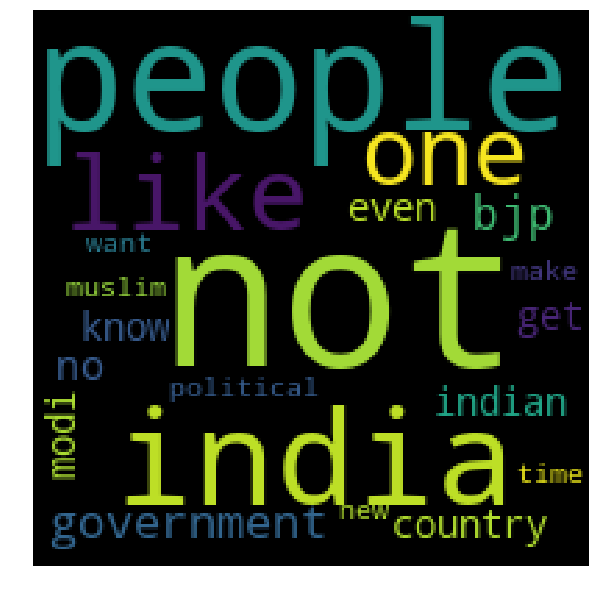

For Flair  Business/Finance


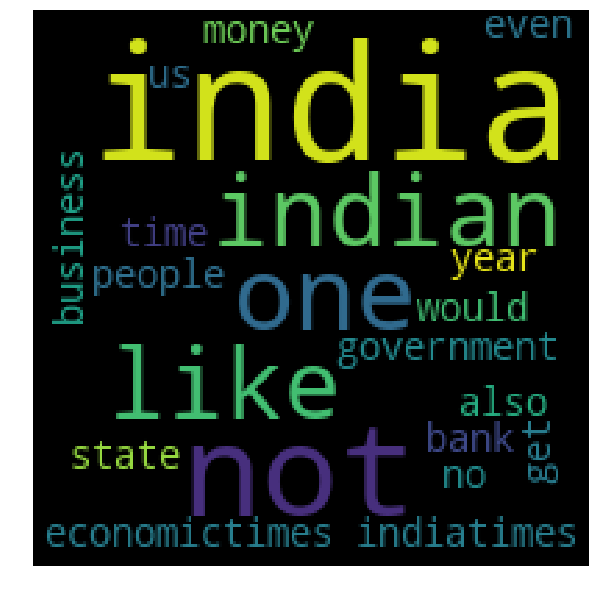

For Flair  Policy/Economy


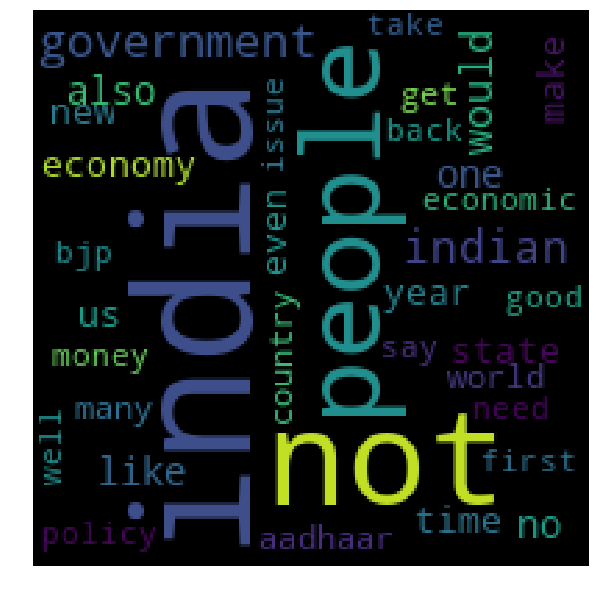

For Flair  Sports


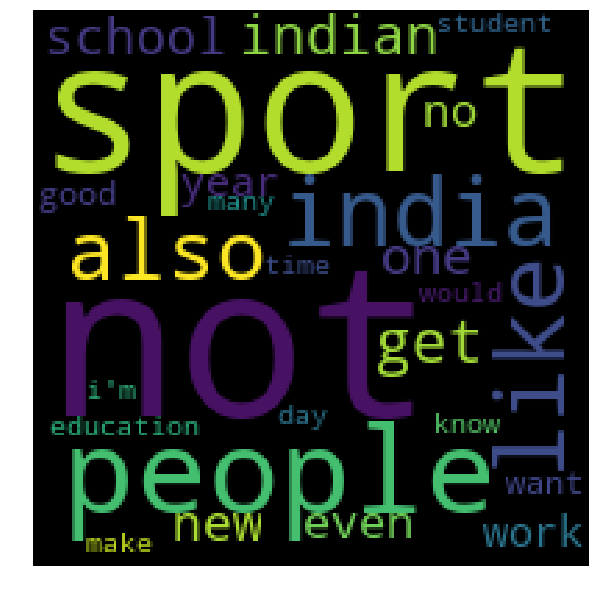

For Flair  Food


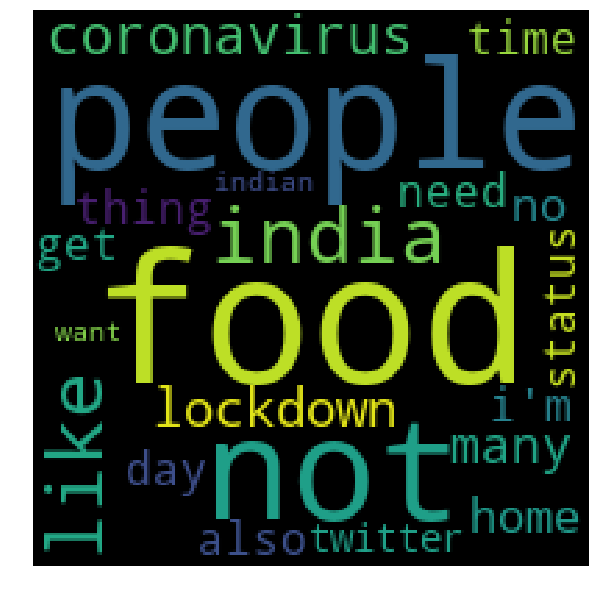

For Flair  AMA


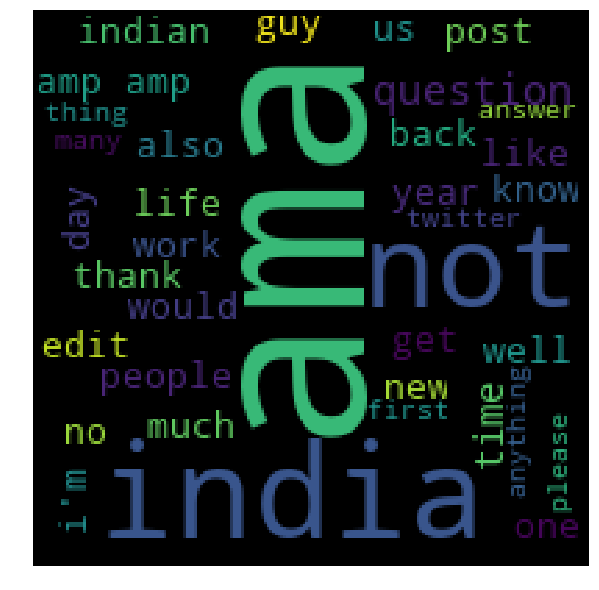

For Flair  Coronavirus


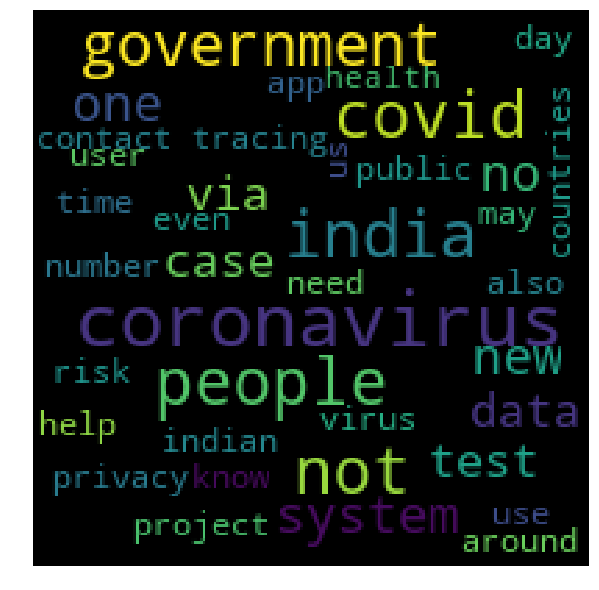

For Flair  CAA-NRC-NPR


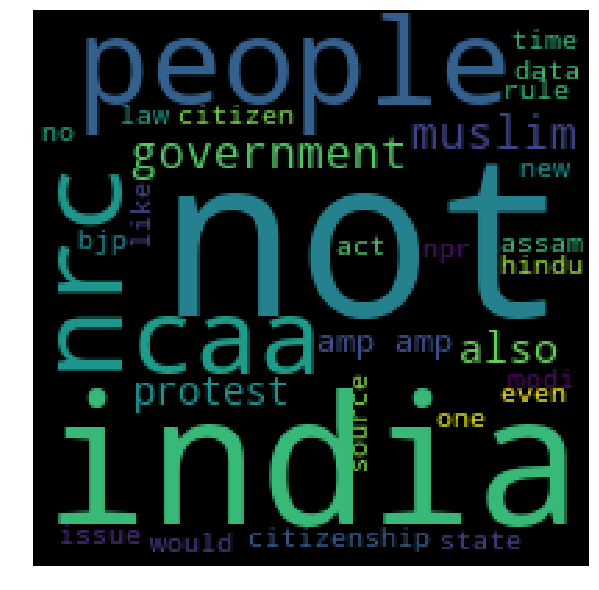

In [53]:
for i in flairs:
    print("For Flair ", i)
    a=df[df['flair']==i]
    
    comment_words = '' 
#     stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for val in a.body: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "
    wordcloud = WordCloud(width = 200, height = 200,  max_words=50,
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

### Top Words in comments for different flairs

For Flair  AskIndia


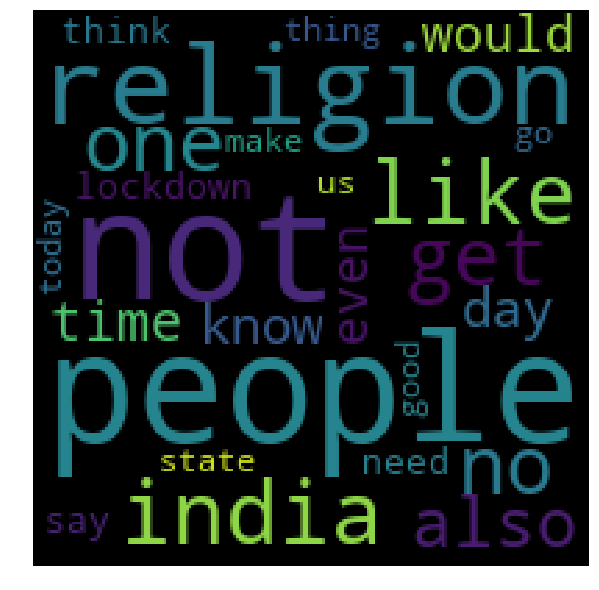

For Flair  Non-Political


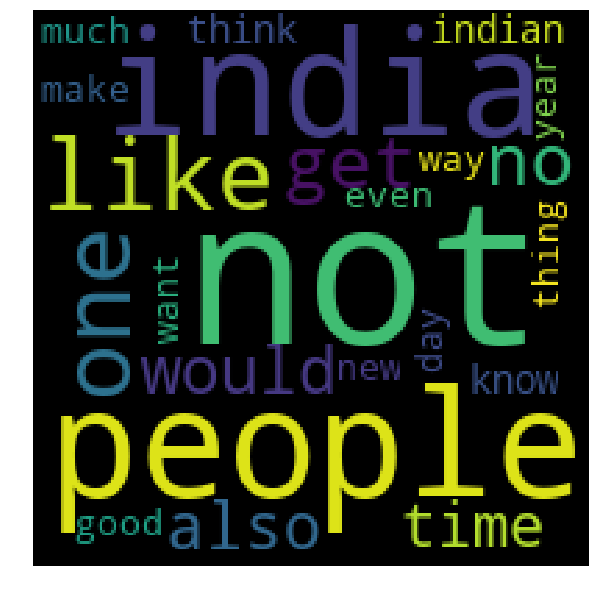

For Flair  [R]eddiquette


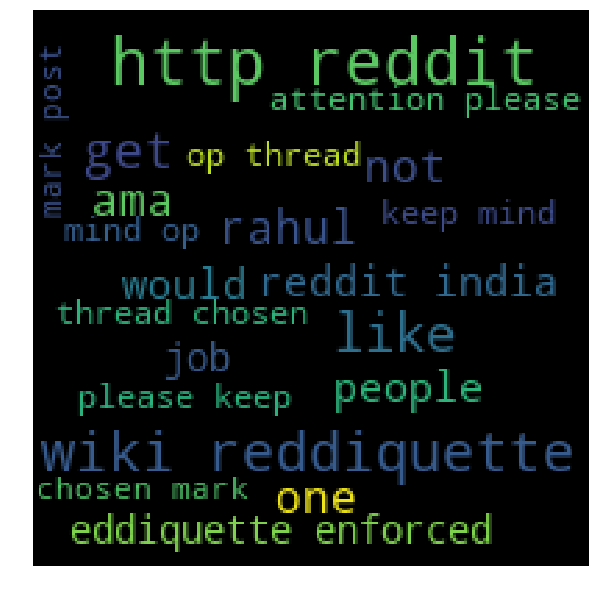

For Flair  Scheduled


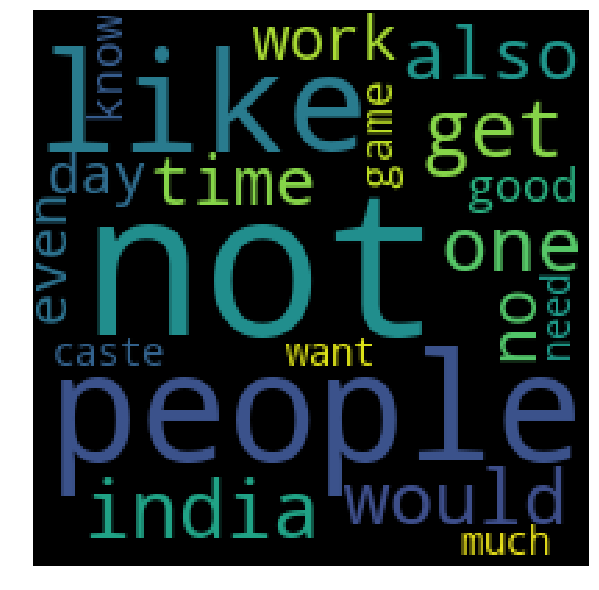

For Flair  Photography


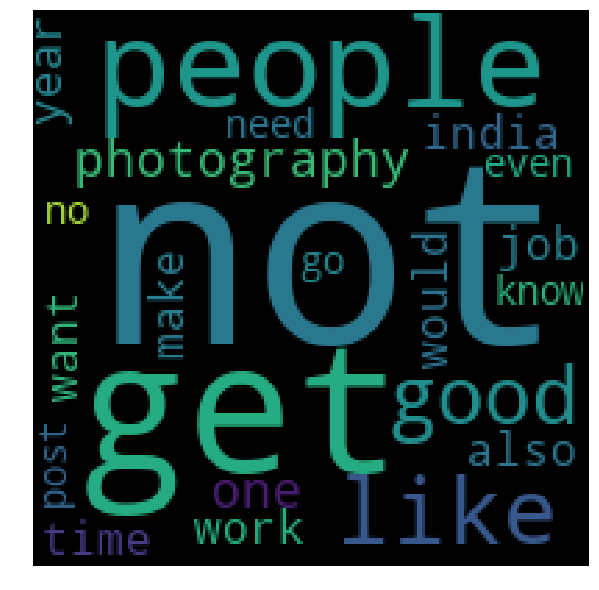

For Flair  Science/Technology


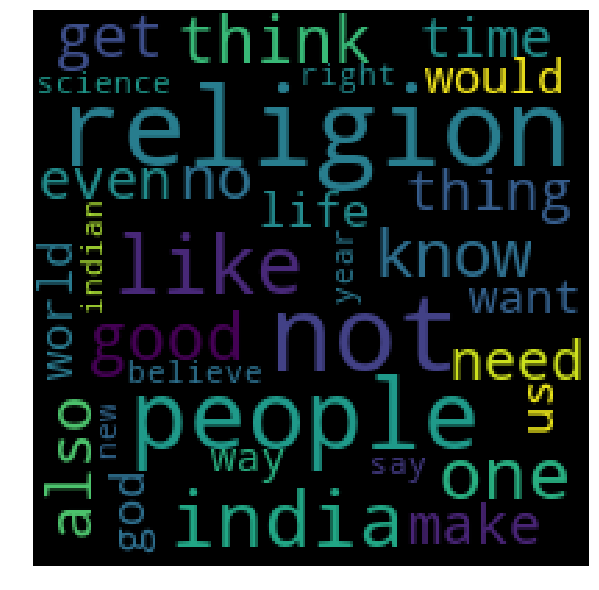

For Flair  Politics


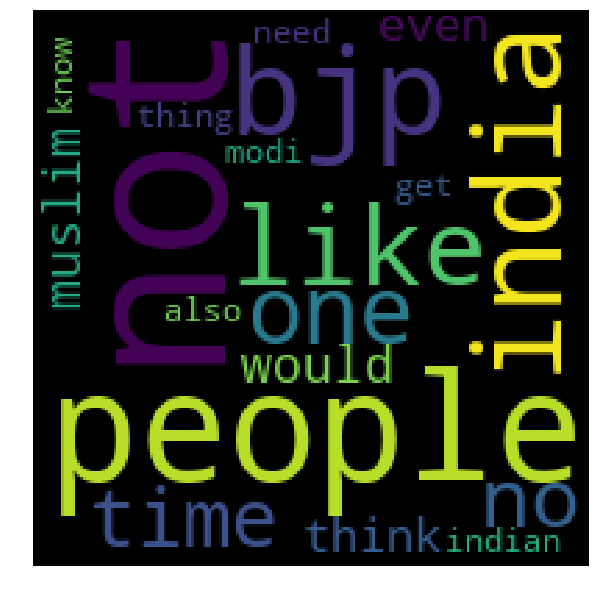

For Flair  Business/Finance


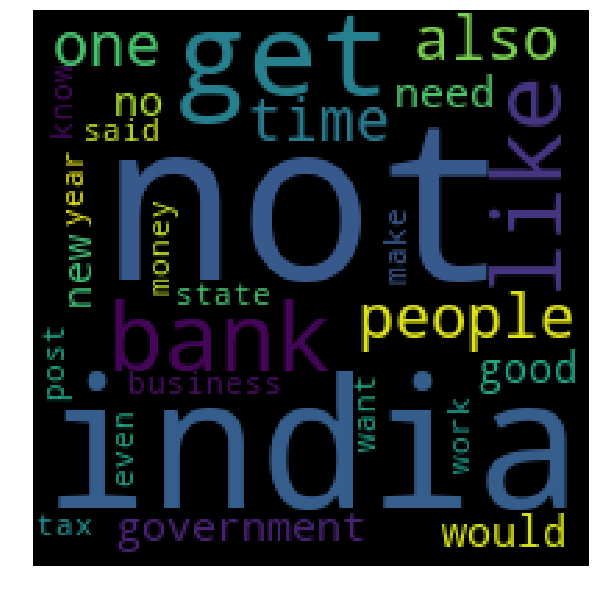

For Flair  Policy/Economy


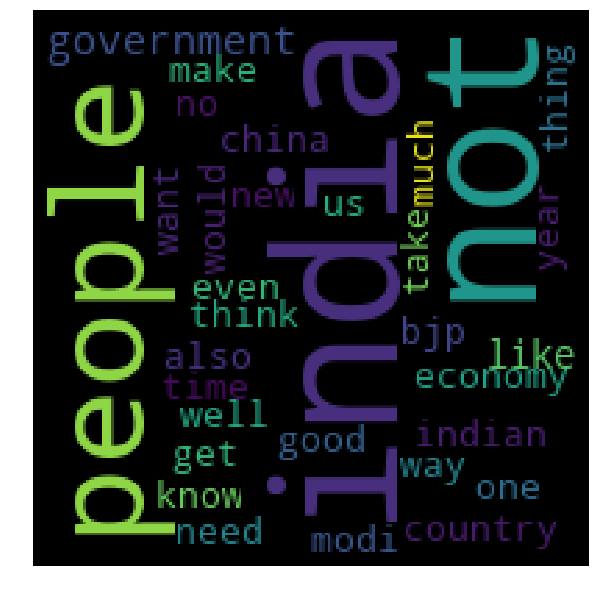

For Flair  Sports


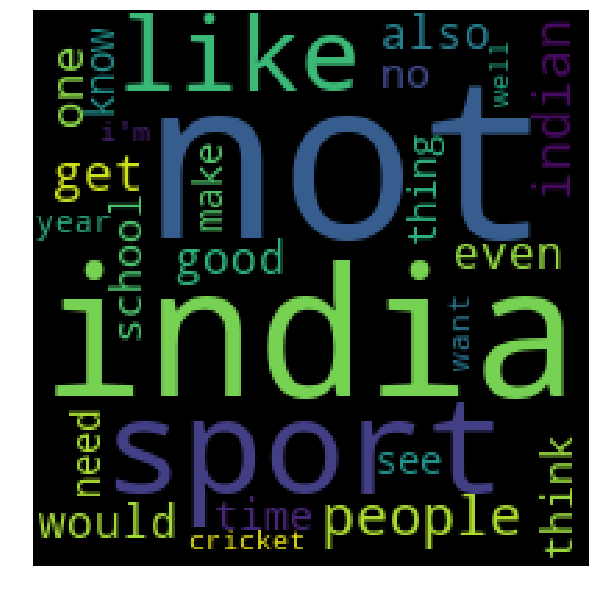

For Flair  Food


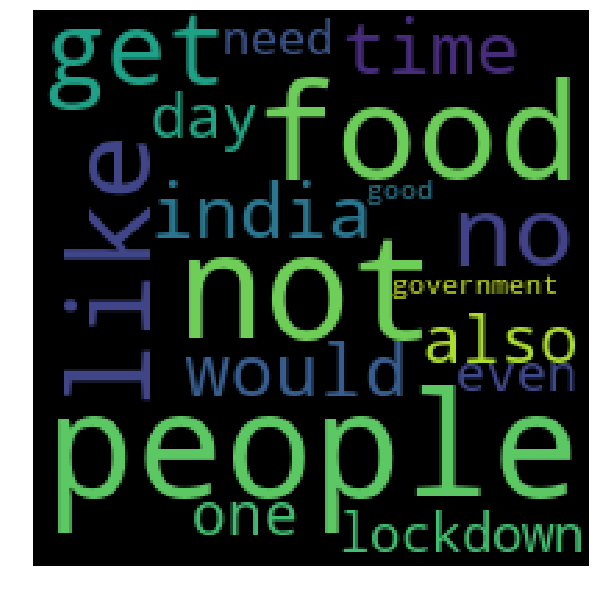

For Flair  AMA


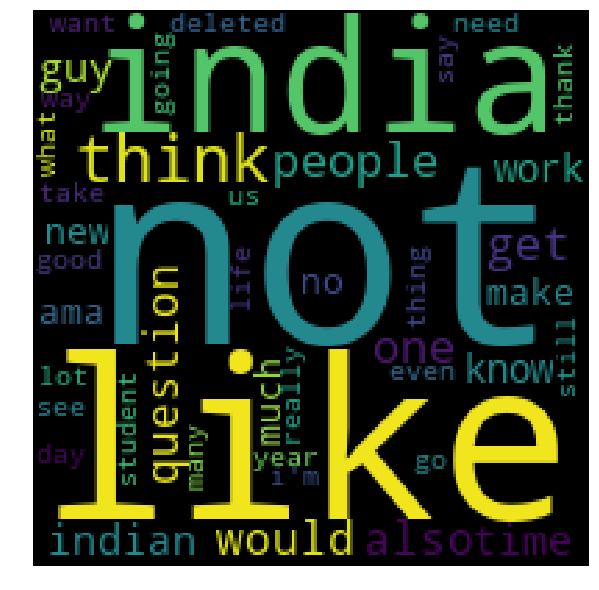

For Flair  Coronavirus


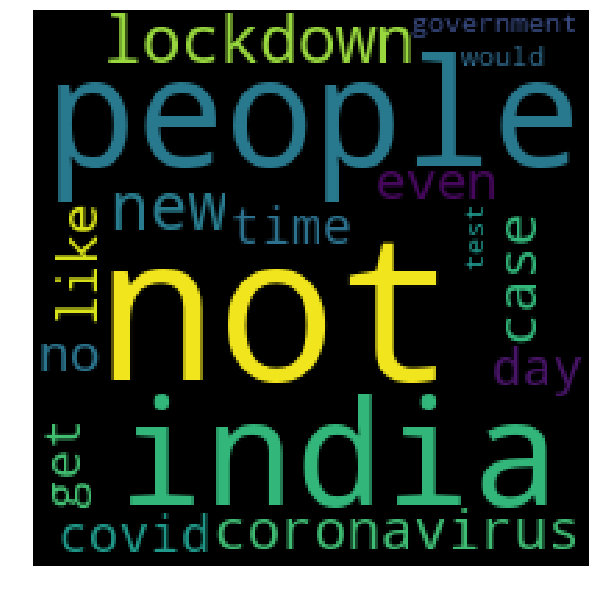

For Flair  CAA-NRC-NPR


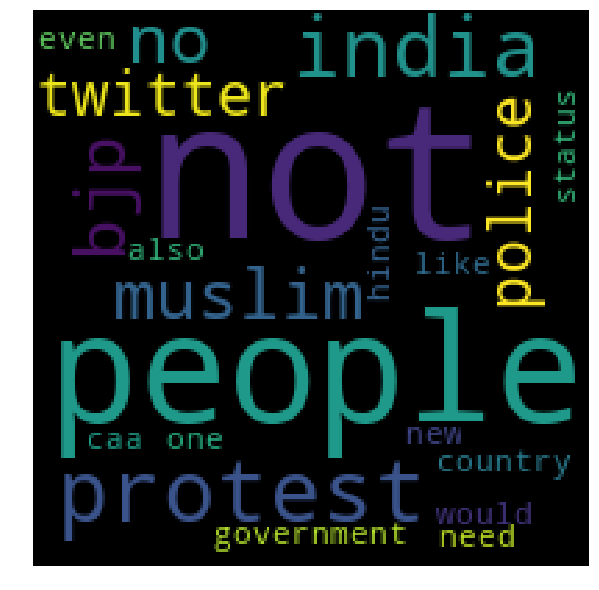

In [54]:
for i in flairs:
    print("For Flair ", i)
    a=df[df['flair']==i]
    
    comment_words = '' 
#     stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for val in a.comments: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "
    wordcloud = WordCloud(width = 200, height = 200,  max_words=50,
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

### Data Cleaning
1. Cell below prepares data so that special characters could be removed

In [55]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


### Cell below combines all forms of text data

In [58]:
df["Text"] = df["title"].map(str) + df["body"].map(str) + df["comments"].map(str) 

In [59]:
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())


100%|█████████████████████████████████████████████████████████████████████████████| 2898/2898 [00:09<00:00, 309.81it/s]

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
y=df['flair'][:]
# y = preprocessing.label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
X=preprocessed_reviews[:]

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)
bow = CountVectorizer()
X_train_bow=bow.fit_transform(X_train)
X_test_bow=bow.transform(X_test)
print(X_train_bow.shape, y_train.shape)

(2028, 44194) (2028,)


In [75]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators = 1000, random_state = 42)

clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=flairs))

accuracy 0.7965517241379311
                    precision    recall  f1-score   support

          AskIndia       0.72      0.94      0.81        72
     Non-Political       0.84      0.75      0.79        63
     [R]eddiquette       0.80      0.78      0.79        76
         Scheduled       0.86      0.91      0.89        35
       Photography       0.67      0.93      0.78        61
Science/Technology       0.88      0.76      0.81        74
          Politics       0.89      0.86      0.87        77
  Business/Finance       0.85      0.85      0.85        62
    Policy/Economy       0.62      0.67      0.64        67
            Sports       0.59      0.63      0.61        62
              Food       0.96      0.66      0.78        74
               AMA       0.85      0.81      0.83        72
       Coronavirus       0.98      0.88      0.93        68
       CAA-NRC-NPR       1.00      0.57      0.73         7

       avg / total       0.81      0.80      0.80       870

